In [70]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from dateutil.parser import parse
from collections import Counter
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from gensim.models import Word2Vec
import pickle
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
pd.set_option("display.max_rows",None)
pd.set_option("display.max_columns",None)

Pre-Processing

In [80]:
data = pd.read_csv('books_1.Best_Books_Ever.csv') #read the data
df = pd.DataFrame(data) #create the dataframe
df = df.dropna(subset=['description','language','genres','pages','publishDate','ratingsByStars'])  #drop the null values of the needed columns from the dataframe

df['ratingsByStars'] = df['ratingsByStars'].str.strip('[]') #remvove [] brackets
df['ratingsByStars'] = df['ratingsByStars'].str.replace("'",'') #remove the ' from each word
df[['ratingStar5','ratingStar4','ratingStar3','ratingStar2','ratingStar1']] = df['ratingsByStars'].str.split(',',expand=True) #split the string by each comma and add the new
#string to each of the new columns created

df['genres'] = df['genres'].str.strip('[]') #remove [] brackets
df['genreSingle'] = df['genres'].str.split(',').str[0].str.strip() #extract only the first string from the stri split method
df['Year'] = pd.to_datetime(df['publishDate'], errors='coerce') #conver the column to datetime object and if we encounter error set the value to null
df = df[df['publishDate'].str.contains(r'\d')] #records that have non-numeric value in publish date remove them from the dataframe

df['Year'] = df['Year'].dt.year #extract the year from the dates

Questions for extracting data (5 in total)

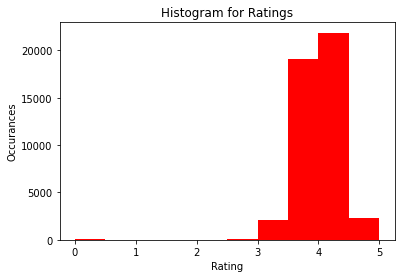

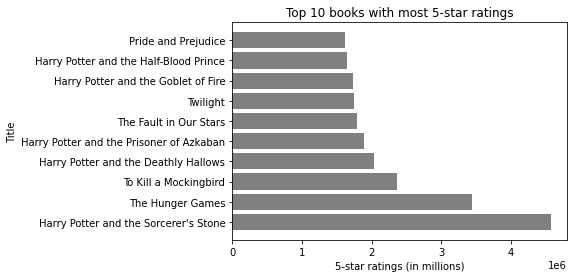

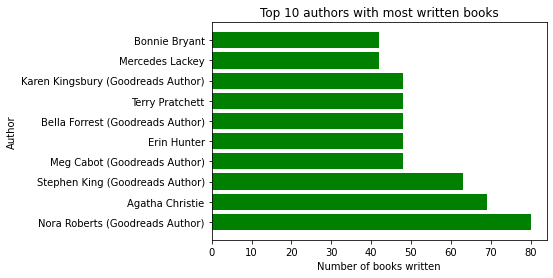

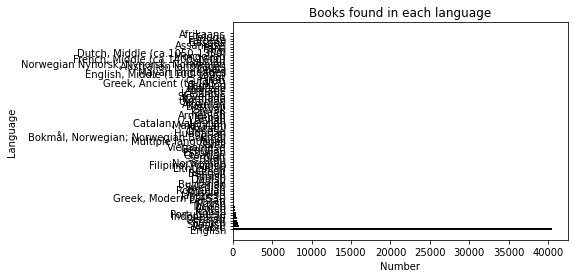

In [87]:
#1st graph (1.1 Question)
plt.hist(df['rating'],color='red')  #show the rating column of dataframe in a histogram
plt.title('Histogram for Ratings')
plt.xlabel('Rating')
plt.ylabel('Occurances')
plt.show()

#2nd graph (1.2 Question)
#df = df[df['pages'].str.match(r'^\d+$')] #first clean the dataframe for column page 
#df['pages'] = df['pages'].astype(int)   #cast to short the dataframe treating pages as integers and not strings
#dfSortedByPages = df.sort_values('pages', ascending=False,) #sort by descending order the dataframe by the pages column
#df_top10 = dfSortedByPages.head(10)   #get only the top 10 cases
#plt.barh(df_top10['title'], df_top10['pages'], color='blue') #create the bar-chart,on x-axis the number of pages and in y axis the title of the book

#plt.xlabel('Pages') #add labels & title
#plt.ylabel('Title')
#plt.title('Top 10 books with most pages')
#plt.show()

#3rd graph (1.3 Question)
df['ratingStar5'] = df['ratingStar5'].replace(r'^\s*$', 0, regex=True) #fill the whitespace values of column 'page' with a zero digit so to be able to cast to int the column
df['ratingStar5'] = df['ratingStar5'].astype(int)   #cast to sort the dataframe treating pages as integers and not strings
dfNew = df[df['ratingStar5'] > 1000]  #get only the entries with 10.000 and above 5-star ratings first
dfSortedByPages = dfNew.sort_values('ratingStar5', ascending=False,) #sort by descending order the dataframe by the pages column
df_top10 = dfSortedByPages.head(10)   #get only the top 10 cases
plt.barh(df_top10['title'], df_top10['ratingStar5'], color='grey') #create the bar-chart,on x-axis the number of 5-star ratings and in y axis the title of the book

plt.xlabel('5-star ratings (in millions)') #add labels & title
plt.ylabel('Title')
plt.title('Top 10 books with most 5-star ratings')
plt.show()

#4rd graph (1.5 Question)
dfNew = df['author'].value_counts()  #distinct each author of the dataframe how many books has written
dfNew = dfNew.head(10)   #get only the 10 top frequent authors of the dataframe
plt.barh(dfNew.index,dfNew.values, color='green')

plt.xlabel('Number of books written') #add labels & title
plt.ylabel('Author')
plt.title('Top 10 authors with most written books')
plt.show()

#5rd graph (1.8 Question)
dfNew = df['language'].value_counts()  #distinct each language of the dataframe how many books are written in each
plt.barh(dfNew.index,dfNew.values, color='black')

plt.xlabel('Number') #add labels & title
plt.ylabel('Language')
plt.title('Books found in each language')
plt.show()

Recommendation system

In [ ]:
#BookId,Description,“English” as language
df = df[df['language'] == 'English'] #omit the books that are not written in English
vectorizer = TfidfVectorizer(ngram_range=(1, 2), stop_words='english') #create a TfidfVectorizer object to extract unigrams and bigrams without stopwords of english language

# fit the vectorizer to the 'description' column of the DataFrame
tfidf = vectorizer.fit_transform(df['description']) #transform text to numbers (fitting of vectorizer)
cos_sim = cosine_similarity(tfidf) #calculate the similarity of each row of a DataFrame and every other row

similar_rows = {}   #intializing the empty directory
for i in range(cos_sim.shape[0]):  #loop through each book and find the 100 most similar books for each
    idx = cos_sim[i].argsort()[-102:-2] #sort the cosine similarity scores in ascending order and get last 100 values(since we need the most similar) omiting the first one that is itself
    idx = idx[idx != i] # exclude the current row from the list of similar rows
    similar_rows[i] = idx.tolist() # store the indices of the similar rows in a dictionary

for key, value in similar_rows.items():
    print(f"Book {key}: {value}")

Classification

In [ ]:
common_words = Counter(df['genreSingle']) #count how many books correspond to each genre

most_common = common_words.most_common(10) #keep the 10 most common

most_common_genres = [] #the most common method returns a tuple containing the genre name and
for word,count in most_common: #the number of the occurences for each genre in the dataframe
    most_common_genres.append(word) #so we split the tuple and keep only the genre name

new_df = df.copy() #create a copy of the dataframe
new_df = new_df[new_df['genreSingle'].apply(lambda x: any(word in x for word in most_common_genres))]
#apply a lamdba function to keep only the books that are in the 10 most common genres

columns_keep = ['genreSingle','description','bookId'] #we want to keep only these 3 columns
new_df = new_df.drop(columns=[col for col in new_df.columns if col not in columns_keep]) #delete the columns which are not in the list above

new_df['description'] = new_df['description'].str.lower() #make all words lower case
stop  = stopwords.words('english') #initialize stop words to english language
pat = r'\b(?:{})\b'.format('|'.join(stop)) #regex expression
new_df['description'] = new_df['description'].str.replace(pat,'',regex=True) #apply regex expr
new_df['description'] = new_df['description'].str.replace(r'\s+',' ',regex=True)
cleaned = []
elements = list(new_df['description']) 
for i in elements : #iterate over all elements in the description column
    FilteredText = re.sub('https?://[A-Za-z0-9./]+','',i) #clean also the links from each element of the column
    FilteredText = re.sub("[^a-zA-Z0-9]", " ",FilteredText) #clean also punctuation
    cleaned.append(re.sub(r'^RT[\s]+', '', FilteredText))
new_df['description'] = cleaned
new_df['description'] = new_df['description'].apply(lambda x: x.split()) #split the text in a list of lists
model = Word2Vec(new_df['description'],vector_size=200,window=5,min_count=2,sg=1,hs=0,negative=10,workers=4,seed=34) #initialize word2vec model
model.train(new_df['description'],total_examples=len(new_df),epochs=20) #train it

with open('W2V.pkl' ,"wb") as file: #open it
    pickle.dump(model,file) #save the model
with open('df.pkl' ,"wb") as file: #open it
    pickle.dump(new_df,file) #save the model


In [ ]:
with open('df.pkl',"rb") as file:
    new_df = pickle.load(file) #open dataframe
df2 = df.copy() #to be changed
new_df = df2

vectorizer = TfidfVectorizer() #use a vectorizer on the data
X = vectorizer.fit_transform(new_df['description'])

y = new_df['genreSingle'] #split data to train test split
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=42)

clf = GaussianNB() #Naive Bayes method
clf.fit(X_train.toarray(),y_train)
y_pred = clf.predict(X_test.toarray())
print('Accuracy of GaussianNB classifier on training set: {:.2f}'.format(clf.score(X_train.toarray(),
y_train)))
print('Accuracy of GaussianNB classifier on test set: {:.2f}'.format(clf.score(X_test.toarray(), y_test)))